
# Exercise 3 -  Text mining 


In [ ]:
! pip install --quiet gensim

In [254]:
import re
from re import sub, split
import pandas as pd
import numpy as np

In [260]:
# Our data
yelps = pd.read_csv('data/yelps.csv').sample(frac=1.)


#### Define a tokenize function

In [261]:
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize

def clean_yelp(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

def tokenize(s):
    """ Returns a list of strings (tokens) from the document """
    ##there are no empty list in yelds
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    tokenize= pattern.findall(s)
    return tokenize

    # Implement this function!
    # Hint: If you look at the sklearn source code on github, 
    # you will find a good regular expression they use as a default
    # tokenizer in CountVectorizer -- this is the tokenizer
    # we have been using until now!
    # But you need to implement your own now. 

#### Creating a count vectorizer  for a Latent Semantic Analysis

In [262]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

vectorizer = CountVectorizer(preprocessor = clean_yelp, tokenizer=tokenize)
# vector representation (TF matrix)
V = vectorizer.fit_transform(yelps.text)
# PCA of TF matrix
svd = TruncatedSVD(n_components=100)
yelp_transformed = svd.fit_transform(V)



# Create a count vectorizer, using the preprocessor and tokenizer from above
# use TruncatedSVD from Sklearn to generate a term embedding matrix for your data
# that is 100 dimensional in size.
# Embed your documents via that term embedding matrix (this is just the PCA of the 
# TF matrix, as returned by "transform" on TruncatedSVD

# Here you should have TWO vector representations of your Yelp data: 
# 1. The original TF matrix
# 2. The first 100 components of the PCA of that matrix, as performed by TruncatedSVD

C:\Users\Rodrigo\Anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\Rodrigo\Anaconda3\lib\site-packages\bs4\__init__.py:336: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\Rodrigo\Anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\Rodrigo\Anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'..'"

#### Training on a small part of the data

In [263]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
def test_holdout_vectors(V, y, cutoff):
    model = LogisticRegression()
    model.fit(V[:cutoff], y[:cutoff])
    preds = model.predict(V[cutoff:])
    return accuracy_score(preds, y[cutoff:])

# Test your vector representations using the above function, test_holdout_vectors. 
# for several levels of "cutoff". 

# This function simulates training on a small part of your data and testing on the rest.
# Thus, it's as though you have some labelled data but a bunch of unlabelled data. 
# This is essentially a semi-supervised situation. 

# Do the word embeddings generated via SVD allow you to pull information from the 
# unlabeled data and improve your score given a small training set?

### Do the word embeddings generated via SVD allow you to pull information from the unlabeled data and improve your score given a small training set?

No, it does improve the score for a small training set. For a training sample of 1000 the accuracy score decreases when I use word embeddings generated via SVD. 

- It's worth noting that the accuracy depends heavily on the amount of the training data. 


In [264]:
cutoff=[1000, 10000, 50000, 75000, 80000, 85000]
scores_svd=[]
for coff in cutoff:
    score=test_holdout_vectors(V=V, y=yelps.positive, cutoff=coff)
    scores_svd.append(score)
scores_svd

[0.9008989898989899, 0.9480666666666666, 0.95924, 0.9622, 0.96255, 0.9636]

In [265]:
cutoff=[1000, 10000, 50000, 75000, 80000, 85000]
scores_svd2=[]
for coff in cutoff:
    score=test_holdout_vectors(V=yelp_transformed, y=yelps.positive, cutoff=coff)
    scores_svd2.append(score)
scores_svd2

C:\Users\Rodrigo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Rodrigo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Rodrigo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Rodrigo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Rodrigo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

[0.8633838383838384, 0.8908666666666667, 0.89544, 0.89368, 0.8943, 0.8936]

### Word2Vec
Given that there is a lot of data, I use a small sample to run faster.

In [266]:
import gensim 
from time import time
import multiprocessing
from gensim.models import Word2Vec
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

# Next, create another term embedding via Word2Vec, also 100 dimensional
# Look at the documentation from the library gensim and see what hyperparameters
# you can choose to tune. 
# Note: training takes time, so you probably won't want to try too many!

# pass the cleaned and tokenized yelp reviews as "sentences" to your model
# to build the vocabulary and train the word vectors.

In [267]:
# use the embed_w2v function to embed your Yelp reviews using the new
# word2vec word embeddings. Each review will be a normalized sum of the
# words that it is made of. 
# See how this improves the scores in the classification task using
# test_holdout_vectors -- is word2vec better? At what training-set sizes does it help
# more?

####  Perform on a smaller sample of the data

In [285]:
yelps = pd.read_csv('data/yelps.csv')

yelps_text = yelps.text[0:500]
yelps_clean_sentence=yelps_text.map(clean_yelp)
yelps_tokenized_sentences = yelps_clean_sentence.map(tokenize)

In [293]:
#yelps = pd.read_csv('data/yelps.csv')

yelps_sample = yelps.sample(500)

yelps_clean_sentence=yelps_sample.text.map(clean_yelp)
yelps_tokenized_sentences = yelps_clean_sentence.map(tokenize)

In [294]:
# Set values for various parameters
min_word_count = 5    # Minimum word count
num_workers = cores-1  # Number of threads to run in parallel
#context = 2           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words
t = time()
W2Vmodel = Word2Vec(yelps_tokenized_sentences,
                    workers=cores-1,
                    size=100,
                    min_count=min_word_count,
                    window=5,
                    sample=downsampling
                   )
# train the model
W2Vmodel.train(yelps_tokenized_sentences, 
               total_examples = W2Vmodel.corpus_count, 
               epochs = W2Vmodel.iter)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

C:\Users\Rodrigo\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "
C:\Users\Rodrigo\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


Time to train the model: 6.31 mins


In [295]:
# Using the "embed_w2v" function to embed Yelp reviews using the new
# word2vec word embeddings. Each review will be a normalized sum of the
# words that it is made of. 


import numpy as np

def embed_w2v(tokens, w2v):
    idxs = [w2v.wv.vocab.get(t) for t in tokens]
    idxs = [t.index for t in idxs if t]
    N = w2v.wv.vectors.shape[1]
    if len(idxs) < 1:
        return np.zeros(N)
    a = np.sum(w2v.wv.vectors[idxs, :], axis=0)
    a /= np.linalg.norm(a)
    return a


word_embed=  np.array([embed_w2v(t,W2Vmodel) for t in yelps_tokenized_sentences ])
word_embed.shape

(500, 100)

###  word2vec works better?
- At what training-set sizes does it help more?

It works better for  a training set that is about 70% of the total sample, then the score decrease as we work with sample larger then 70% as we can see above.  


In [308]:
# test_holdout_vectors -- is word2vec better? At what training-set sizes does it help
# more?
cutoff=[100, 150, 200, 300, 350, 400, 450]
scores=[]
for coff in cutoff:
    score=test_holdout_vectors(V=word_embed, y=yelps_sample.positive, cutoff=coff)
    scores.append(score)
scores

C:\Users\Rodrigo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Rodrigo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Rodrigo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Rodrigo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Rodrigo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

[0.5525, 0.56, 0.56, 0.545, 0.5866666666666667, 0.57, 0.58]

## Second part: Tweets

In [309]:
import pandas as pd
import re
from functools import reduce
import spacy

pats = [re.compile(r'https?:\/\/[^\s]+'), 
        re.compile(r'rt\s*@\w+\s?:?'),
        re.compile(r'@\w+')]

def clean_twitter(s):
    """ Cleans Twitter specific issues
    
    Should probably clean out mentions, URLs, and RT's.
    """
    s = s.lower()
    _sub = lambda s,pat: re.sub(pat, '', s)
    s = reduce(_sub, pats, s)
    s = ' '.join(s.split()).strip()
    pat1=r'@\S+|https?[^\s]+|rt\s+|[^\w+]'
    pat2=r'\s+[a-zA-Z]\s+|\s+'
    pat3=r'^\s+|\s+$'
    tex_clean=sub(pat1," ", s)
    text_space=sub(pat2," ", tex_clean)
    output = sub(pat3,"", text_space)
    
    # TODO: Use regular expressions to remove unwanted
    # text and clean up our tweets to be more usable!
    sp = spacy.load('en_core_web_sm')
    sentence=sp(output)
    # Extract part-of-speech and lemmatize this sentence.
    #part_of_speech = [(x.orth_,x.pos_, x.lemma_) for x in [y 
    #                                  for y
    #                                  in sentence 
    #                                  if not y.is_stop and y.pos_ != 'PUNCT']]
    #Named entity extraction 
    #entity = dict([(str(x), x.label_) for x in sentence.ents])
    #lemmatize
    lemmatize=" ".join([word.lemma_ for word in sentence])
    # BONUS: Try using the library "spacy" to 
    # do further processing, such as lemmatizing
    # or replacing Named Entities with constants (i.e. "[NAMED]")
    # or adding the part of speech or dependency code to the word 

    return lemmatize

In [388]:
# Load tweet!
# NOTE: this file needs to be downloaded from Box! 


with open('data/tweets.txt', encoding="utf8") as f:
    tweets = pd.Series(f.readlines())

####  Perform on a smaller sample of the data

In [389]:
tweets = tweets[1:501]

In [390]:
tweets_cleaned= tweets.map(clean_twitter)

In [391]:
tweets_tokenized= tweets_cleaned.map(tokenize)

In [393]:
# Now embed this twitter data, again using Word2Vec and LSA (SVD)
# you don't have any labels, but you might be able to 
# find some interesting phenomena. 

# Explore using either or both of the following tools: 
# 1. Word2Vec has a built in feature for getting most similar
# words, including via positive/negative examples (subtraction)
# What happens when you subtract "hillary" from "trump"? 

# Bonus: build a similar feature for your LSA features and
# see if you can do similar vector math

# 2. Use the visualize_dist function to see how
# the tweet-tweet distance looks for a selection
# of random tweets. Do you agree with the distance? 
# Does one embedding seem better than another?

## Explore using either or both of the following tools: 
1. Word2Vec has a built in feature for getting most similar
- words, including via positive/negative examples (subtraction)
- What happens when you subtract "hillary" from "trump"?

###  Word2Vec

In [394]:
t = time()
tweet_model= Word2Vec(tweets_tokenized,
                    workers=cores-1,
                    size=20,
                    min_count=5,
                    window=5,
                    sample=1e-3
                   )
# train the model
tweet_model.train(tweets_tokenized, 
               total_examples = W2Vmodel.corpus_count, 
               epochs = W2Vmodel.iter)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

C:\Users\Rodrigo\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "
C:\Users\Rodrigo\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  if sys.path[0] == '':


Time to train the model: 0.1 mins


In [395]:
tweet_model.most_similar(positive=['trump'], negative=['hillary'])

C:\Users\Rodrigo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('neverhillary', 0.09212177246809006),
 ('stop', 0.0566721074283123),
 ('would', 0.044837936758995056),
 ('over', 0.044597890228033066),
 ('receive', 0.0409679040312767),
 ('maga', 0.0403035506606102),
 ('election', 0.03705039620399475),
 ('i', 0.03435015678405762),
 ('where', 0.03219423443078995),
 ('bill', 0.03147703409194946)]

In [396]:
word_embeding=  np.array([embed_w2v(t, tweet_model) for t in tweets_tokenized ])
word_embeding.shape

(500, 20)

In [405]:
# Embedded tweets #2 --> using TruncatedSVD
vectorizer = CountVectorizer(preprocessor = clean_twitter, tokenizer=tokenize)
V = vectorizer.fit_transform(tweets)
# PCA of TF matrix
tweet_SVD = TruncatedSVD(n_components=20).fit_transform(V)
tweet_SVD.shape



(500, 20)

In [398]:
# Visualization  with heatmap

from scipy.spatial.distance import pdist,squareform
import seaborn as sns

def visualize_dist(V, tokenized_tweets, idxs):
    
    
    #V is the vector of embeddings 
    #tweets is a list or series that converts from idx to tweet
    #idxs is a list of integers that you would like to compare (<= 5 probably)
    
    m = squareform(pdist(V[idxs], 'cosine'))
    
    _ = sns.heatmap(pd.DataFrame(m, columns = tokenized_tweets[idxs], index= tokenized_tweets[idxs]))

In [ ]:
# 2. Use the visualize_dist function to see how
# the tweet-tweet distance looks for a selection
# of random tweets. Do you agree with the distance? 
# Does one embedding seem better than another?

#### you agree with the distance? Does one embedding seem better than another?
- I agree with the distance since the words that seems to be related each other have smaller distances. 
- It seems that tweet-tweet distance with a SVD model works better than Word2Vec model. 

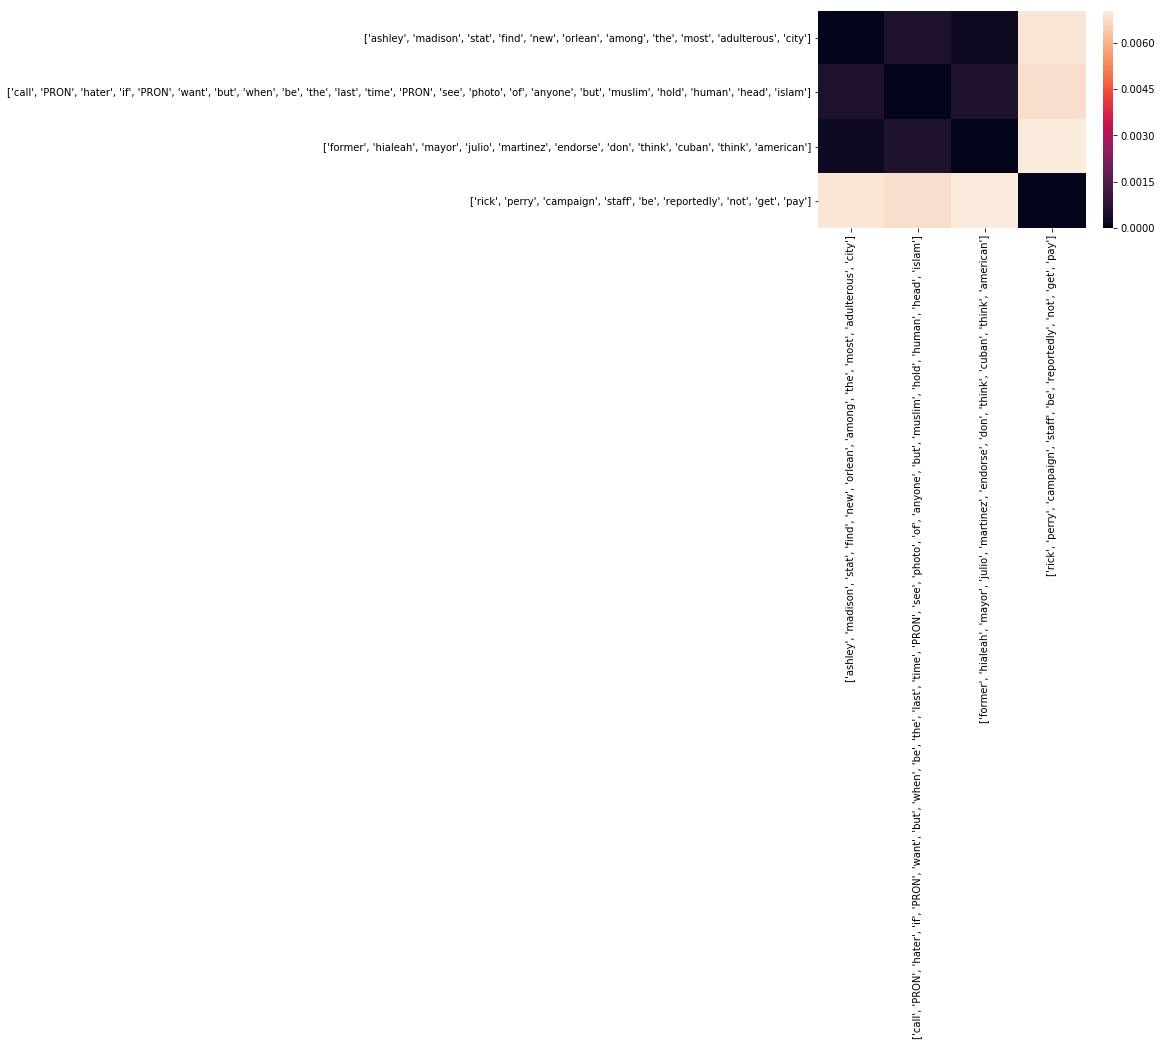

In [401]:
# Visualize tweet-tweet distance for a selection of random tweets 

idxs= [1,2,3,4] ## random tweets

visualize_dist(word_embeding, tweets_tokenized, idxs)

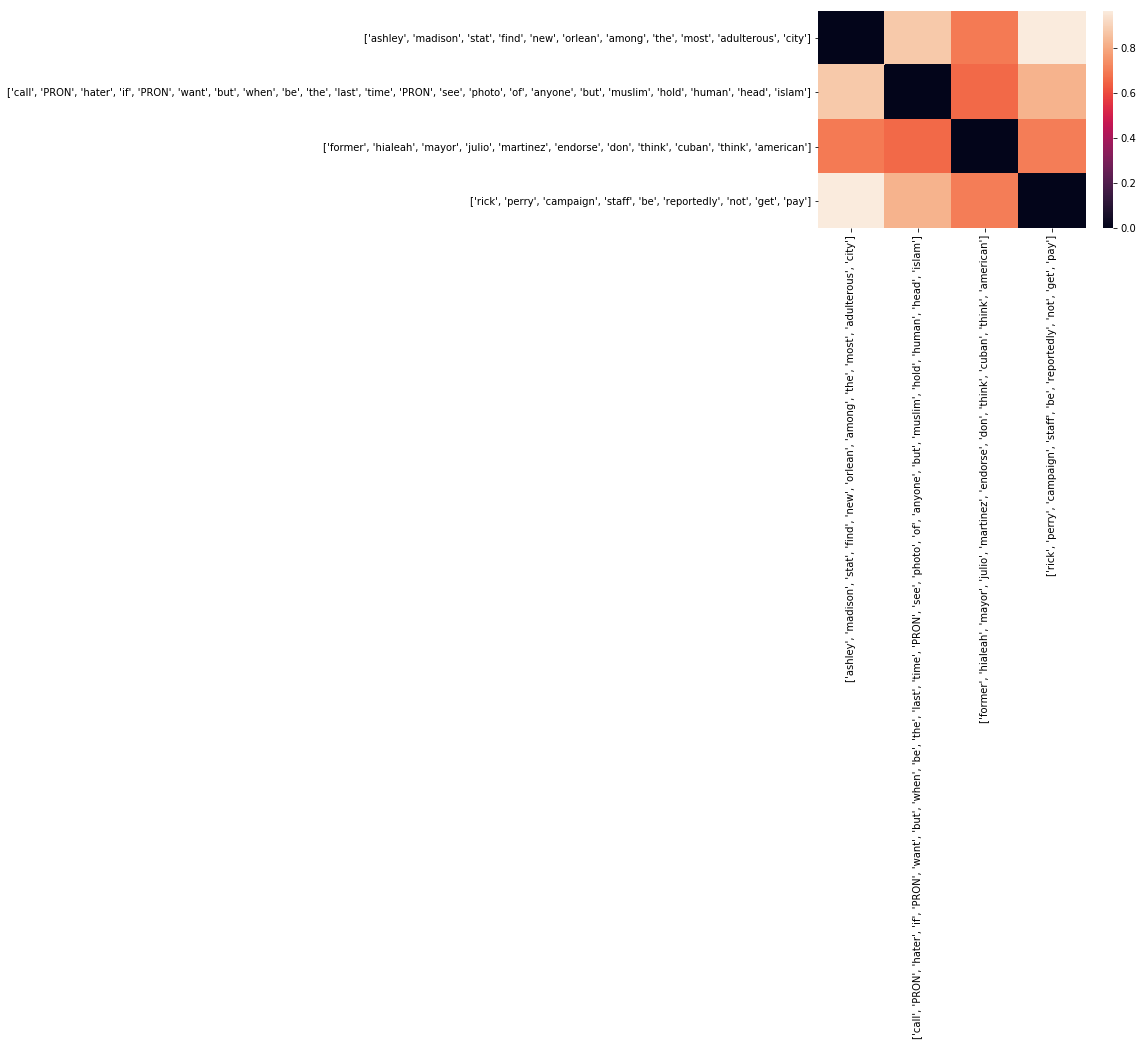

In [404]:
idxs= [1,2,3,4]

visualize_dist(tweet_SVD, tweets_tokenized, idxs)

In [ ]:
# More bonus!
# Use one of the following pre-embedded models and see if your yelp scores improve? 
# What about your Twitter explorations?

# https://github.com/RaRe-Technologies/gensim-data

In [ ]:
!pip install glove_python

In [ ]:
import glove
from glove import Corpus, Glove

In [ ]:
# creating a corpus object
corpus = Corpus()

In [ ]:
corpus.fit(tweets_tokenized, window=10)

In [ ]:
glove = Glove(no_components=100, learning_rate=0.05)

In [ ]:
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)

In [ ]:
glove.add_dictionary(corpus.dictionary)

In [ ]:
glove.save('glove.model')

In [ ]:
print glove.word_vectors[glove.dictionary['Trump']]}
#This will print the embeddings for the word “Trump”.